Basic SVM

In [2]:
import zipfile
import pandas as pd
import os

# General packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn import metrics
from sklearn import model_selection

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, SelectKBest, SelectFdr, chi2, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, learning_curve, cross_val_score
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score


Functions

In [4]:
def t_plot_learning_curve(X_train, y_train, classifier, scoring, clf_type):
    if scoring == 'error':
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5),
            scoring='accuracy',
            train_sizes=np.linspace(0.1, 1.0, 50),
            n_jobs=-1
        )
        train_scores_mean = 1-np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = 1-np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
    else:
        train_sizes, train_scores, test_scores = learning_curve(
            classifier,
            X_train,
            y_train,
            cv=StratifiedKFold(n_splits=5),
            scoring=scoring,
            train_sizes=np.linspace(0.1, 1.0, 50),
            n_jobs=-1
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(f"Learning Curve ({clf_type})")
    plt.xlabel("Number of training objects")
    plt.ylabel(scoring)

    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="blue")

    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="green")

    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [5]:
# Load data
with zipfile.ZipFile(os.path.join('tm10007_ml','ecg','ecg_data.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

# Divide data into test and train
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)


K=100

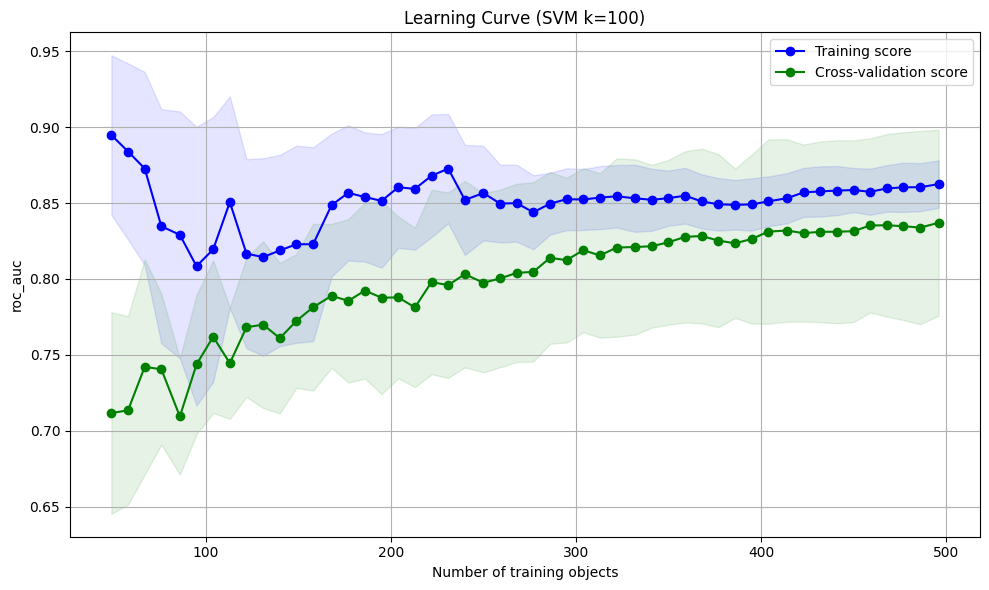

Number of Features Selected after RFECV: 15
Gemiddelde ROC AUC: 0.8369882639728443


In [6]:
# ====== PRE-FEATURE SELECTION ======
# Apply Power Transformation to handle skewed data
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=100)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# Cross validation
cv = StratifiedKFold(n_splits=5)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

t_plot_learning_curve(X_selected, y_train, classifier=svm, scoring='roc_auc', clf_type='SVM k=100')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Gemiddelde ROC AUC:", scores.mean())

K=80

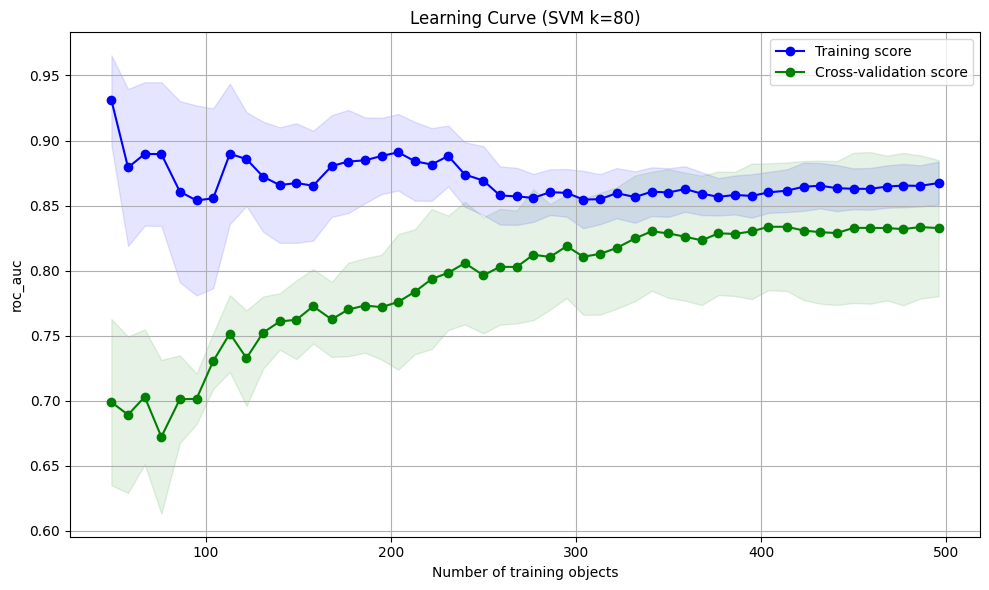

Number of Features Selected after RFECV: 20
Gemiddelde ROC AUC: 0.8327092001849283


In [9]:
# ====== PRE-FEATURE SELECTION ======
# Apply Power Transformation to handle skewed data
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=80)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# Cross validation
cv = StratifiedKFold(n_splits=5)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

t_plot_learning_curve(X_selected, y_train, classifier=svm, scoring='roc_auc', clf_type='SVM k=80')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Gemiddelde ROC AUC:", scores.mean())

K=60

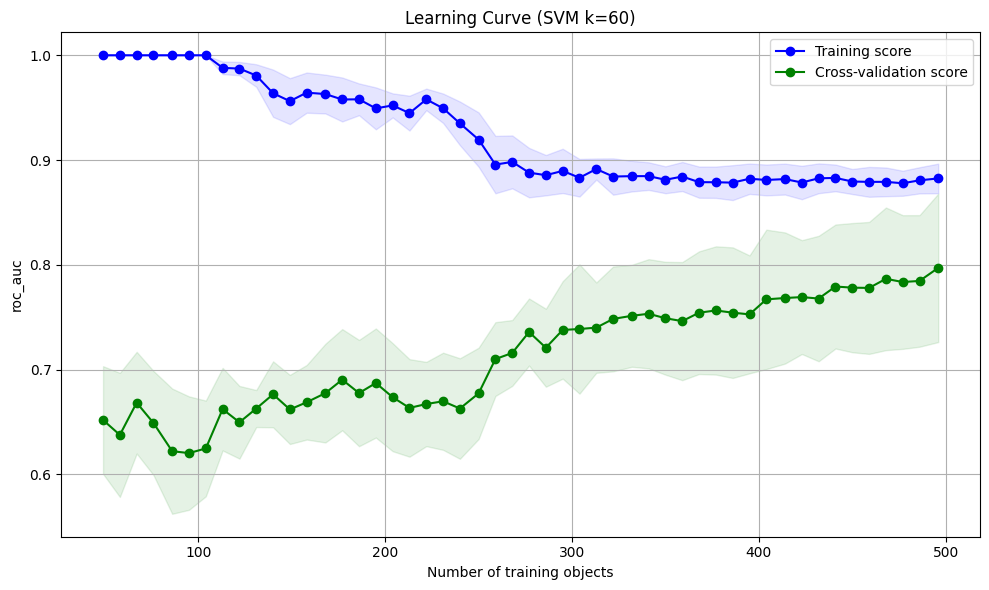

Number of Features Selected after RFECV: 55
Gemiddelde ROC AUC: 0.7970729156622932


In [7]:
# ====== PRE-FEATURE SELECTION ======
# Apply Power Transformation to handle skewed data
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=60)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# Cross validation
cv = StratifiedKFold(n_splits=5)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

t_plot_learning_curve(X_selected, y_train, classifier=svm, scoring='roc_auc', clf_type='SVM k=60')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Gemiddelde ROC AUC:", scores.mean())

K=40

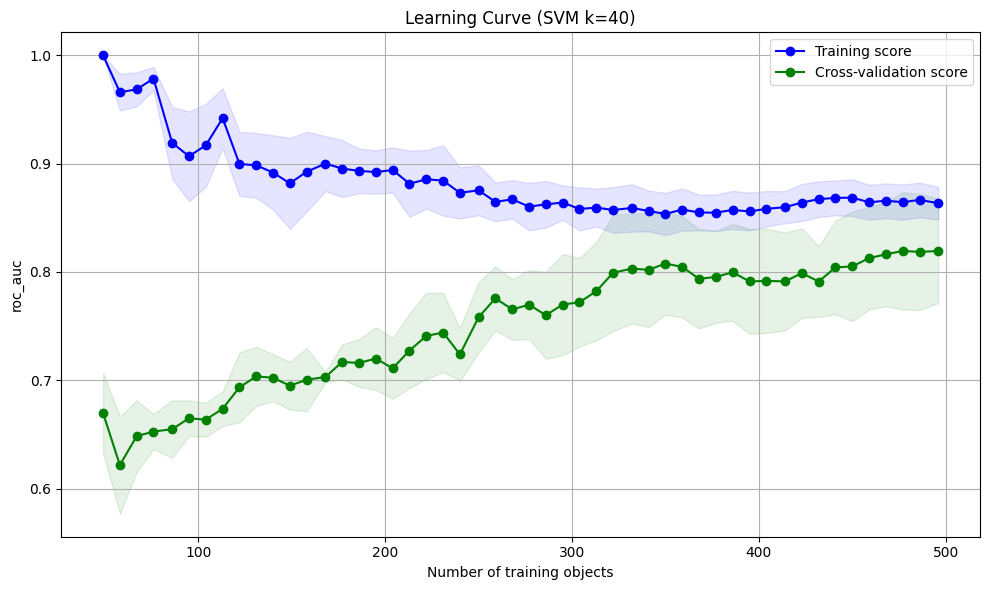

Number of Features Selected after RFECV: 30
Gemiddelde ROC AUC: 0.8194049905928832


In [8]:
# ====== PRE-FEATURE SELECTION ======
# Apply Power Transformation to handle skewed data
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=40)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# Cross validation
cv = StratifiedKFold(n_splits=5)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

t_plot_learning_curve(X_selected, y_train, classifier=svm, scoring='roc_auc', clf_type='SVM k=40')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Gemiddelde ROC AUC:", scores.mean())

K=25

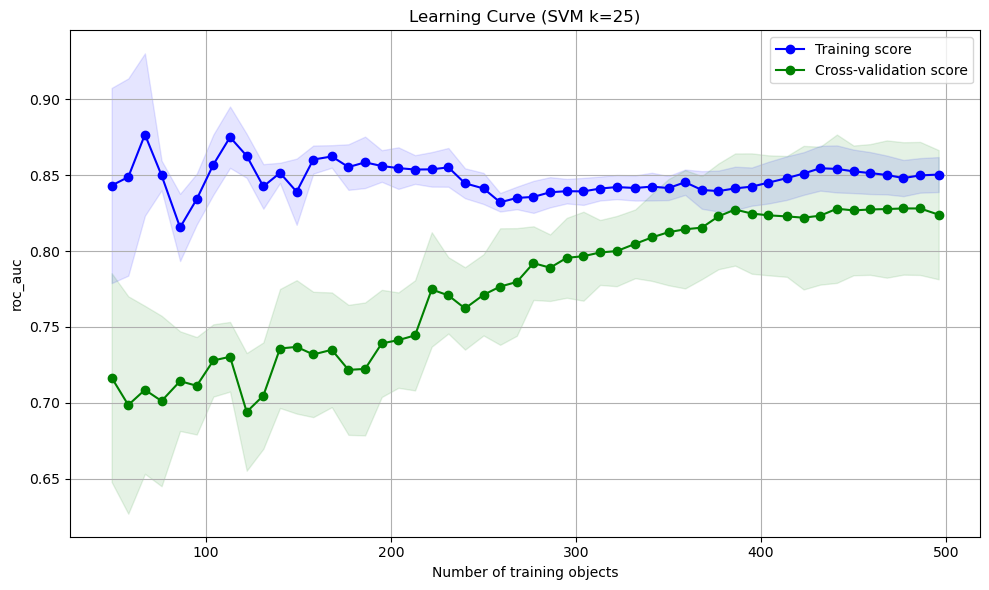

Number of Features Selected after RFECV: 15
Gemiddelde ROC AUC: 0.8239417920742879


In [37]:
# ====== PRE-FEATURE SELECTION ======
# Apply Power Transformation to handle skewed data
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=25)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# Cross validation
cv = StratifiedKFold(n_splits=5)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

t_plot_learning_curve(X_selected, y_train, classifier=svm, scoring='roc_auc', clf_type='SVM k=25')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Gemiddelde ROC AUC:", scores.mean())

K=20

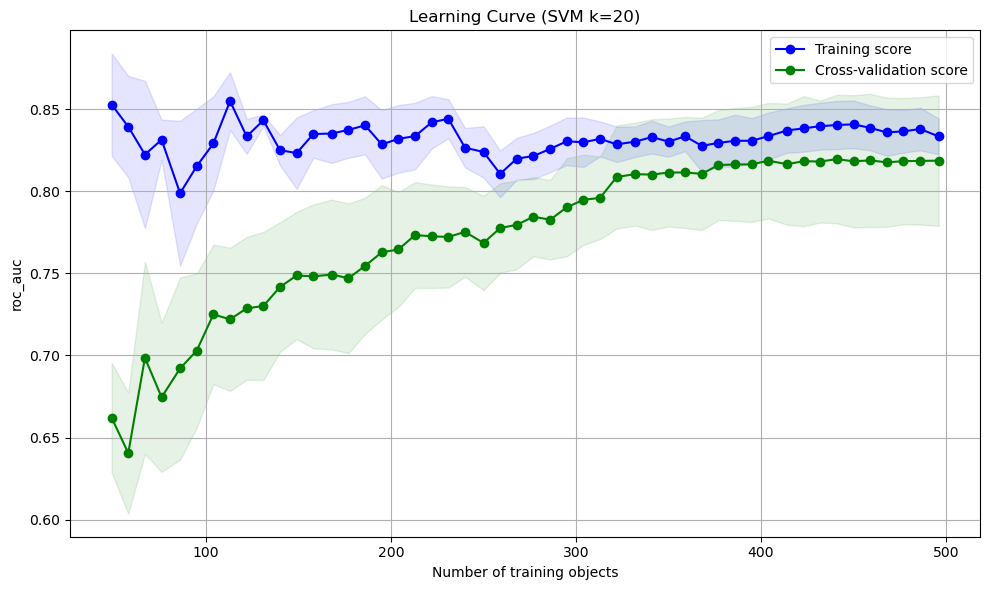

Number of Features Selected after RFECV: 10
Gemiddelde ROC AUC: 0.8187417950410525


In [22]:
# ====== PRE-FEATURE SELECTION ======
# Apply Power Transformation to handle skewed data
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

# Use SelectKBest with mutual_info_classif for fe5ature selection
selector = SelectKBest(mutual_info_classif, k=20)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# Cross validation
cv = StratifiedKFold(n_splits=5)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

t_plot_learning_curve(X_selected, y_train, classifier=svm, scoring='roc_auc', clf_type='SVM k=20')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Gemiddelde ROC AUC:", scores.mean())

K=15

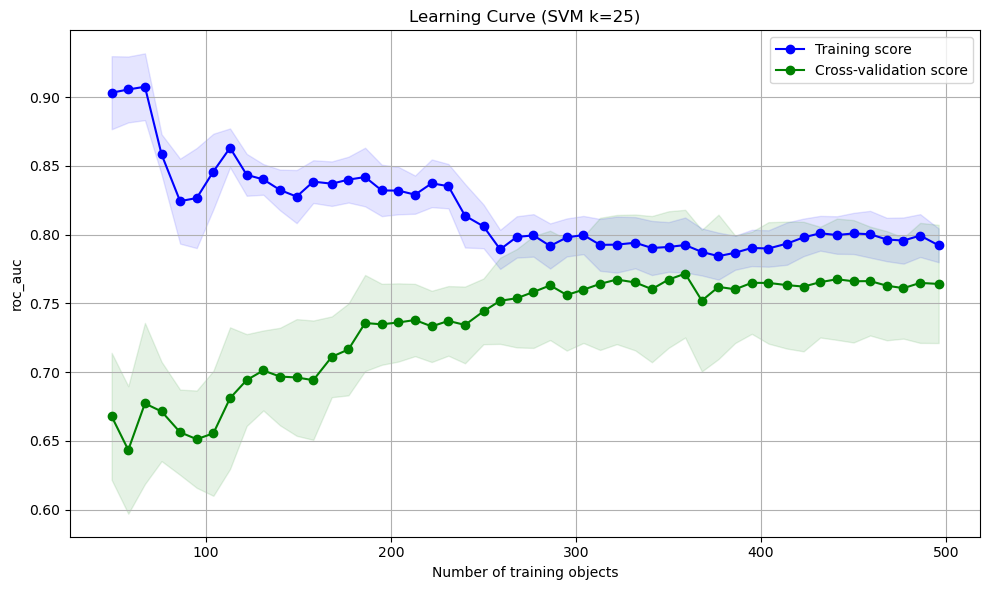

Number of Features Selected after RFECV: 10
Gemiddelde ROC AUC: 0.7641716174554553


In [39]:
# ====== PRE-FEATURE SELECTION ======
# Apply Power Transformation to handle skewed data
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=15)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# Cross validation
cv = StratifiedKFold(n_splits=5)

# ====== FEATURE SELECTION ======
svm = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

t_plot_learning_curve(X_selected, y_train, classifier=svm, scoring='roc_auc', clf_type='SVM k=25')

selected_features = np.where(rfecv.support_)[0]
print(f"Number of Features Selected after RFECV: {len(selected_features)}")
print("Gemiddelde ROC AUC:", scores.mean())

Feature selection

In [50]:
# ====== PRE-FEATURE SELECTION ======
# Apply Power Transformation to handle skewed data
power_transformer = PowerTransformer(method='yeo-johnson')
X_train_transformed = power_transformer.fit_transform(X_train)
X_test_transformed = power_transformer.transform(X_test)

# Use SelectKBest with mutual_info_classif for feature selection
selector = SelectKBest(mutual_info_classif, k=25)
X_train_reduced = selector.fit_transform(X_train_transformed, y_train)
X_test_reduced = selector.transform(X_test_transformed)

# Cross validation
cv = StratifiedKFold(n_splits=5)

# ====== FEATURE SELECTION ======
svm_feature = SVC(kernel="linear", random_state=42)
rfecv = RFECV(estimator=svm_feature, step=5, cv=cv, scoring='roc_auc')
rfecv.fit(X_train_reduced, y_train)
X_selected = rfecv.transform(X_train_reduced)
X_test_selected = rfecv.transform(X_test_reduced)

Kernel = linear

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best estimator: SVC(C=0.001, class_weight='balanced', kernel='linear', max_iter=10000,
    random_state=42, tol=0.0001)
Best Score: 0.8200098397699769
Best parameters: {'tol': 0.0001, 'max_iter': 10000, 'C': 0.001}


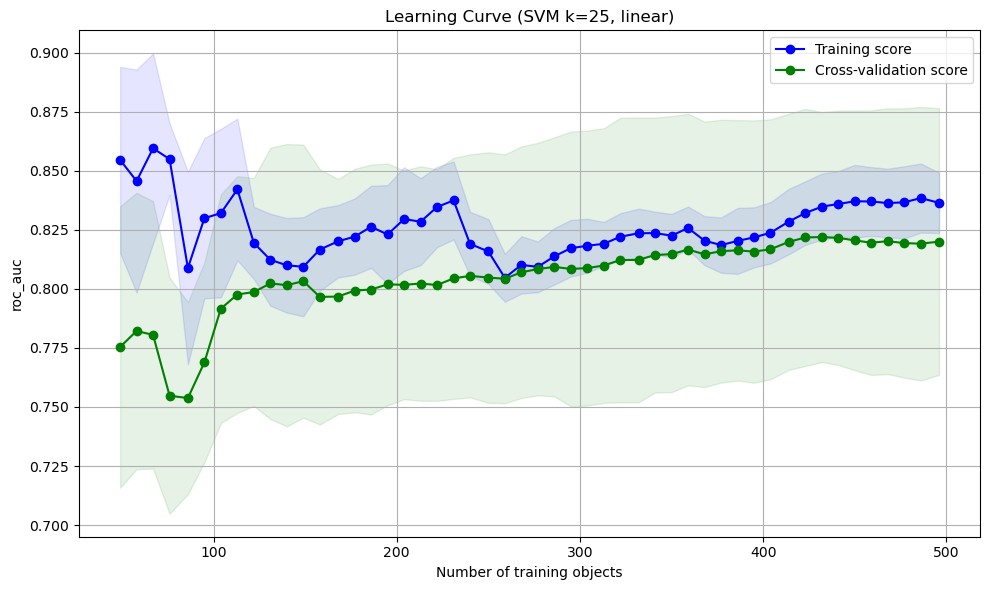

Gemiddelde ROC AUC: 0.8200098397699769


In [60]:
# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="linear", random_state=42, class_weight='balanced')

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

parameters = {
    'C':            [0.001, 0.01, 0.1, 1, 10, 100],
    'tol':          [1e-4, 1e-5, 1e-6],             
    'max_iter':     [1000, 10000, -1]    
}

# ====== EVALUATION  ======
model = RandomizedSearchCV(
    estimator=svm,
    param_distributions=parameters,
    n_iter=20,
    n_jobs=-1,
    cv=cv,
    verbose=1,
    refit=True,
    scoring='roc_auc'  
)

model.fit(X_selected, y_train)

print("Best estimator:", model.best_estimator_ )
print("Best Score:", model.best_score_)
print("Best parameters:", model.best_params_)


pipeline.fit(X_selected, y_train)

t_plot_learning_curve(X_selected, y_train, classifier=model.best_estimator_, scoring='roc_auc', clf_type='SVM k=25, linear')
print("Gemiddelde ROC AUC:", model.best_score_)

Kernel = poly

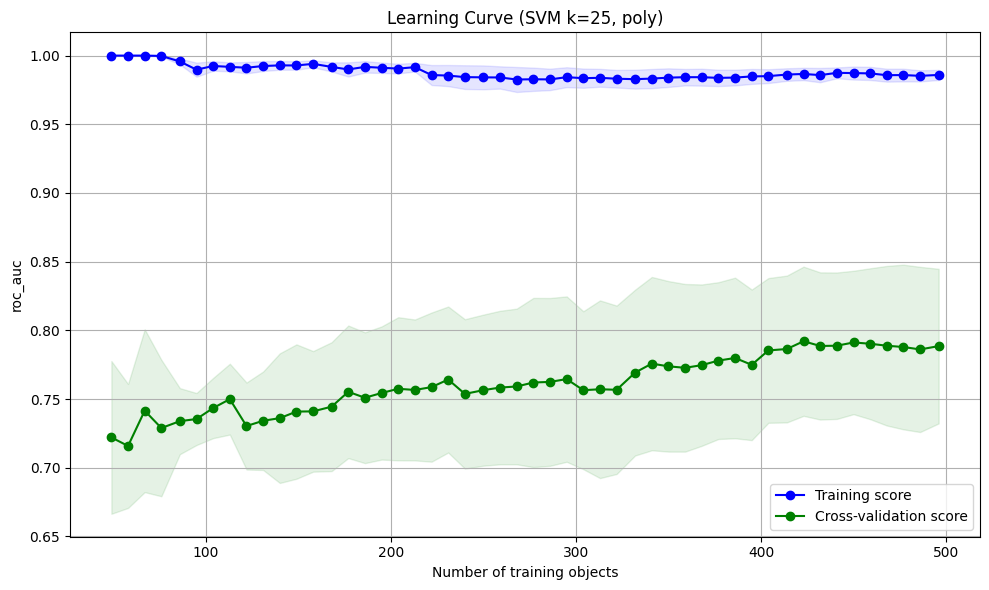

Gemiddelde ROC AUC: 0.7885078656352215


In [ ]:
# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="poly", random_state=42, class_weight='balanced')

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

t_plot_learning_curve(X_selected, y_train, classifier=svm, scoring='roc_auc', clf_type='SVM k=25, poly')
print("Gemiddelde ROC AUC:", scores.mean())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Beste estimator:
 Pipeline(steps=[('svm',
                 SVC(C=10, class_weight='balanced', gamma=0.01, kernel='poly',
                     random_state=42))])
Beste ROC AUC-score: 0.8360679488035284
Beste hyperparameters: {'svm__tol': 0.001, 'svm__max_iter': -1, 'svm__gamma': 0.01, 'svm__C': 10}


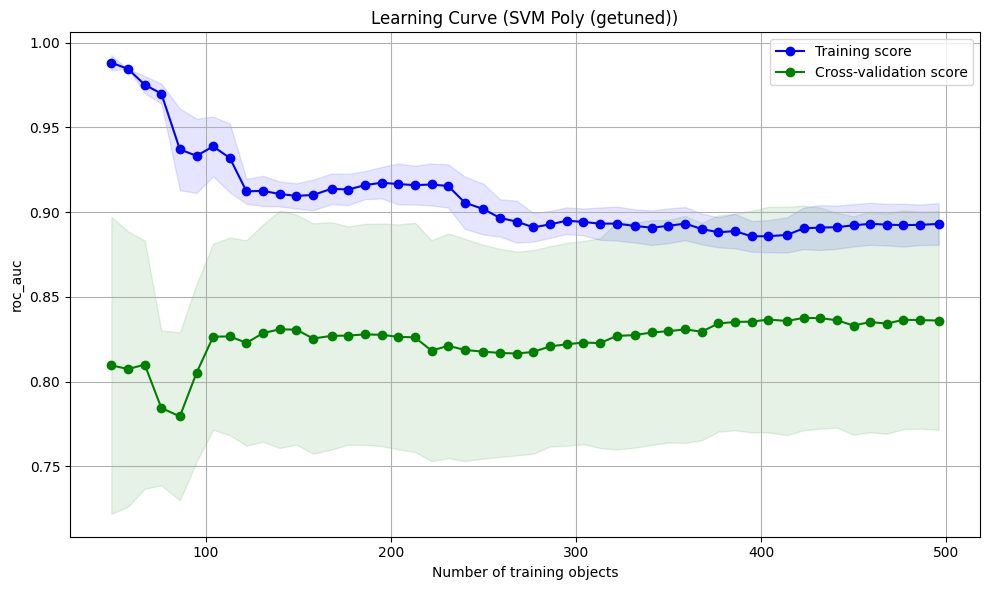

In [17]:
# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(
    kernel="poly",  # Veranderd van 'rbf' naar 'poly'
    random_state=42,
    class_weight='balanced'
)

# ====== PIPELINE ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== HYPERPARAMETER ======
param_grid = {
    'svm__C': [0.1, 1, 10, 100, 1000],
    'svm__gamma': [1e-4, 1e-3, 1e-2, 0.1, 1],
    'svm__tol': [1e-3, 1e-4, 1e-5],
    'svm__max_iter': [1000, 10000, -1]
}

# ====== 3. RANDOMIZED SEARCH MET CROSS-VALIDATIE ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# ====== 4. TRAINING ======
random_search.fit(X_selected, y_train)

# ====== 5. RESULTATEN ======
print("Beste estimator:\n", random_search.best_estimator_)
print("Beste ROC AUC-score:", random_search.best_score_)
print("Beste hyperparameters:", random_search.best_params_)

# ====== 6. LEARNING CURVE PLOT ======
t_plot_learning_curve(
    X_selected,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM Poly (getuned)'
)


Kernel = RBF

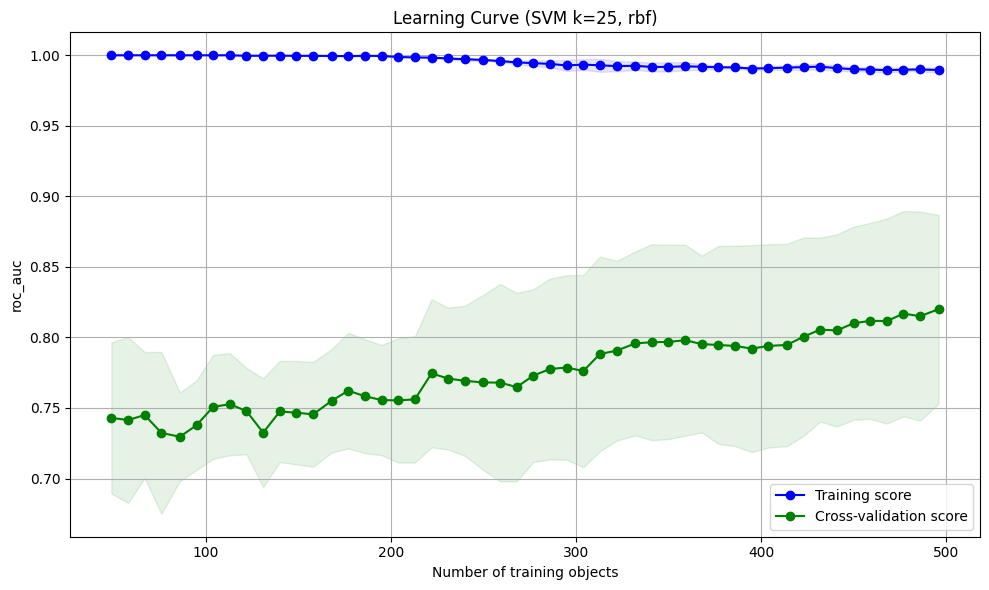

Gemiddelde ROC AUC: 0.8200184928340268


In [ ]:
# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(kernel="rbf", random_state=42, class_weight='balanced')

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== EVALUATION  ======
scores = cross_val_score(
    pipeline,
    X_selected,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

pipeline.fit(X_selected, y_train)

t_plot_learning_curve(X_selected, y_train, classifier=svm, scoring='roc_auc', clf_type='SVM k=25, rbf')
print("Gemiddelde ROC AUC:", scores.mean())

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Beste estimator:
 Pipeline(steps=[('svm',
                 SVC(C=1, class_weight='balanced', gamma=0.01, max_iter=1000,
                     random_state=42, tol=1e-05))])
Beste ROC AUC-score: 0.8370026033361271
Beste hyperparameters: {'svm__tol': 1e-05, 'svm__max_iter': 1000, 'svm__gamma': 0.01, 'svm__C': 1}


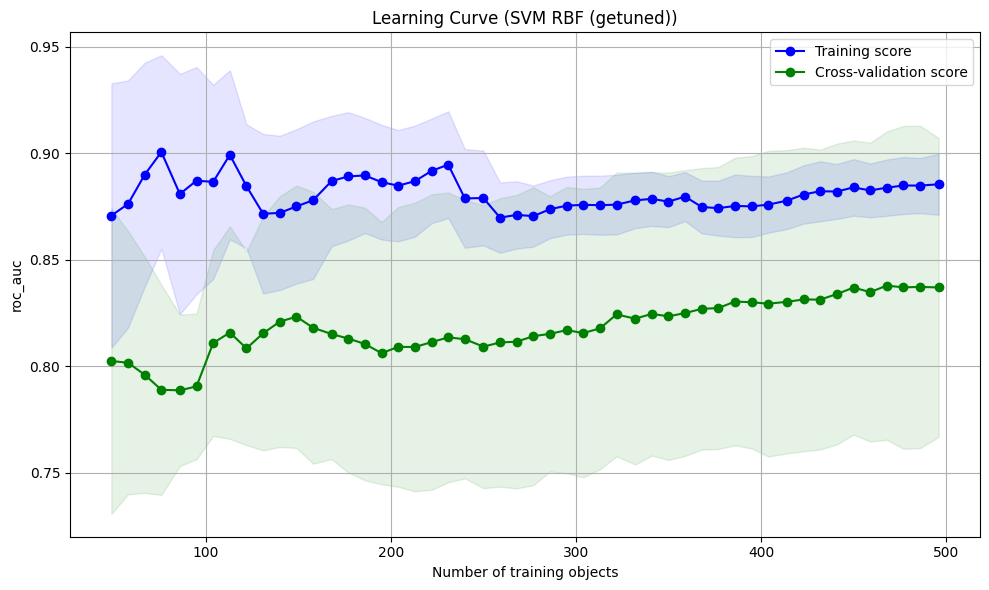

In [11]:
# ====== PIPELINE CHARACTERISTICS ======
svm = SVC(
    kernel="rbf",
    random_state=42,
    class_weight='balanced'
)

# ====== PIPELINE  ======
pipeline = Pipeline([
    ('svm', svm)
])

# ====== HYPERPARAMETER ======
param_grid = {
    'svm__C': [0.1, 1, 10, 100, 1000],
    'svm__gamma': [1e-4, 1e-3, 1e-2, 0.1, 1],
    'svm__tol': [1e-3, 1e-4, 1e-5],
    'svm__max_iter': [1000, 10000, -1]
}

# ====== 3. RANDOMIZED SEARCH MET CROSS-VALIDATIE ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# ====== 4. TRAINING ======
random_search.fit(X_selected, y_train)

# ====== 5. RESULTATEN ======
print("Beste estimator:\n", random_search.best_estimator_)
print("Beste ROC AUC-score:", random_search.best_score_)
print("Beste hyperparameters:", random_search.best_params_)

# ====== 6. LEARNING CURVE PLOT ======
t_plot_learning_curve(
    X_selected,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM RBF (getuned)'
)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Beste ROC AUC-score: 0.8354183509237764
Beste hyperparameters: {'svm__tol': 0.0001, 'svm__max_iter': 1000, 'svm__gamma': 0.01, 'svm__C': 1}


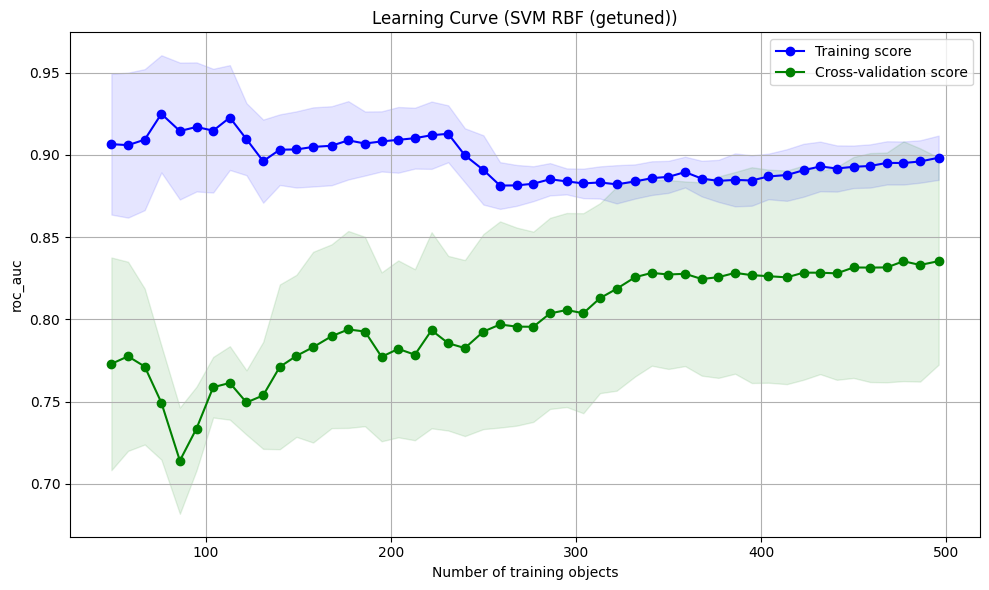

In [ ]:
# ====== SVM & Pipeline Setup ======
pipeline = Pipeline([
    ('svm', SVC(kernel='rbf', class_weight='balanced', random_state=42))
])

# ====== Hyperparameter ======
param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__gamma': [1e-5, 1e-4, 1e-3, 1e-2, 0.1],
    'svm__tol': [1e-3, 1e-4, 1e-5],
    'svm__max_iter': [1000, 10000, -1]
}

# ====== Randomized Search CV ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,            
    scoring='roc_auc',
    cv=cv,                 
    n_jobs=-1,
    verbose=1,
    refit=True
)

# ====== Fit model op trainingsdata ======
random_search.fit(X_selected, y_train)

# ====== Resultaten tonen ======
print("Beste ROC AUC-score:", random_search.best_score_)
print("Beste hyperparameters:", random_search.best_params_)

# ====== LEARNING CURVE PLOT ======
t_plot_learning_curve(
    X_selected,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM RBF (getuned)'
)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Nieuwe beste ROC AUC-score: 0.838980075701949
Nieuwe beste hyperparameters: {'svm__tol': 0.0005, 'svm__max_iter': 10000, 'svm__gamma': 0.009, 'svm__C': 4.5}


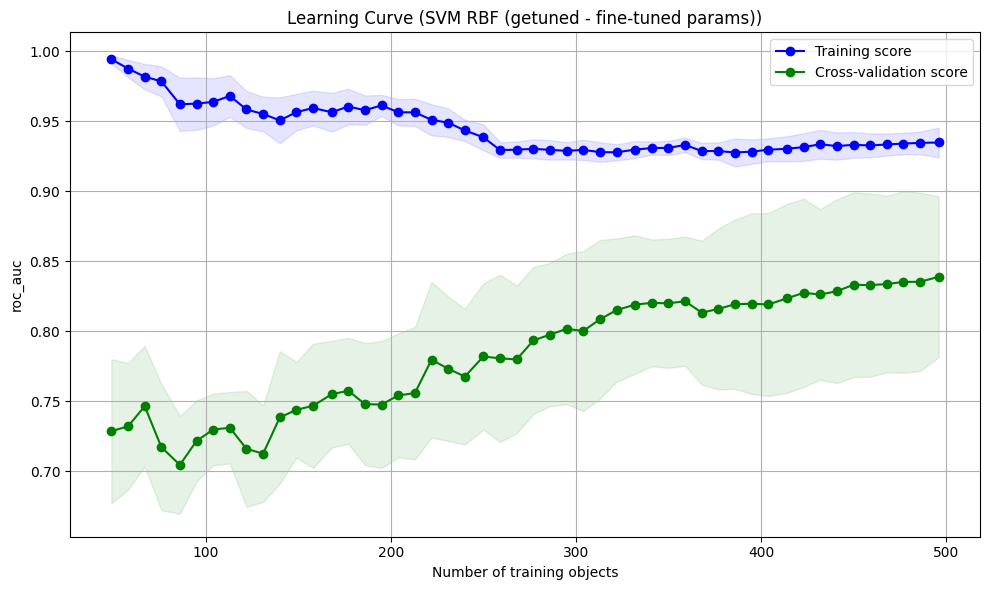

In [56]:
# ====== SVM & Pipeline Setup ======
pipeline = Pipeline([
    ('svm', SVC(kernel='rbf', class_weight='balanced', random_state=42))
])

# ====== Nog fijnmaziger Hyperparameter Ruimte ======
param_grid = {
    'svm__C': [4, 4.5, 5],
    'svm__gamma': [0.0085, 0.009, 0.0095],
    'svm__tol': [3e-4, 5e-4, 7e-4],
    'svm__max_iter': [80000, 10000, -1]
}

# ====== Randomized Search CV ======
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True,
    random_state=42
)

# ====== Fit model op trainingsdata ======
random_search.fit(X_selected, y_train)

# ====== Resultaten tonen ======
print("Nieuwe beste ROC AUC-score:", random_search.best_score_)
print("Nieuwe beste hyperparameters:", random_search.best_params_)

# ====== 6. LEARNING CURVE PLOT ======
t_plot_learning_curve(
    X_selected,
    y_train,
    classifier=random_search.best_estimator_,
    scoring='roc_auc',
    clf_type='SVM RBF (getuned - fine-tuned params)'
)



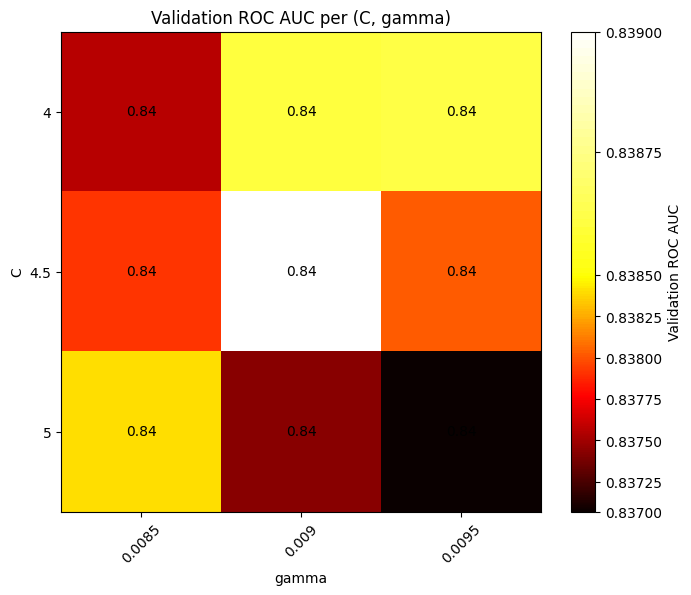

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

# ===== MidpointNormalize class =====
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        return np.ma.masked_array(np.interp(value, [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]))

# ===== Extract C and gamma ranges from param_grid =====
C_range = param_grid['svm__C']
gamma_range = param_grid['svm__gamma']

scores = np.full((len(C_range), len(gamma_range)), np.nan)  # initialize with NaN

for idx, result in enumerate(random_search.cv_results_['params']):
    c_val = result['svm__C']
    gamma_val = result['svm__gamma']
    if c_val in C_range and gamma_val in gamma_range:
        c_idx = C_range.index(c_val)
        gamma_idx = gamma_range.index(gamma_val)
        scores[c_idx, gamma_idx] = random_search.cv_results_['mean_test_score'][idx]

# ===== Plot heatmap =====
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)

plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(
        vmin=np.nanmin(scores),
        midpoint=np.nanmedian(scores),
        vmax=np.nanmax(scores)
    )
)

plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar(label='Validation ROC AUC')
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation ROC AUC per (C, gamma)")

# ===== ROC =====
for i in range(len(C_range)):
    for j in range(len(gamma_range)):
        if not np.isnan(scores[i, j]):
            plt.text(j, i, f"{scores[i, j]:.2f}", ha='center', va='center', color='black')

plt.show()

